In [84]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [87]:
batch_size = 8
lr = 1e-4
epochs = 100
height = 336
width = 336

In [88]:
dataset_path = os.path.join("dataset","/content/drive/MyDrive/segmentation_folder")

files_dir = os.path.join("files","/content/drive/MyDrive/segmentation_folder")
model_file = os.path.join(files_dir, "unet-non-aug.keras")
log_file = os.path.join(files_dir, "log-non-aug.csv")

In [89]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [90]:
create_dir(files_dir)

In [91]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu") (x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu") (x)

    return x

In [92]:
##Encoder Block

In [93]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

In [94]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=(2,2), padding="same")(inputs)
    x = Concatenate() ([x, skip])
    x = conv_block(x, num_filters)
    return x

In [95]:
def build_unet(input_shape):
    inputs = Input(shape=input_shape)

    """Encoder"""
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """Bridge"""
    b1 = conv_block(p4, 1024)

    """Decoder"""
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [96]:
##Dataset Pipeline

In [97]:

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*")))
    train_y = sorted(glob(os.path.join(path, "train", "masks", "*")))

    valid_x = sorted(glob(os.path.join(path, "valid", "images", "*")))
    valid_y = sorted(glob(os.path.join(path, "valid", "masks", "*")))

    return (train_x, train_y), (valid_x, valid_y)


In [98]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    return x

In [99]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [100]:
def tf_parse(x,y):
    def _parse(x,y):
        x = read_image(x)
        y = read_mask(y)
        return x,y

    x, y = tf.numpy_function(_parse, [x,y], [tf.float64, tf.float64])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])

    return x,y

In [101]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset. from_tensor_slices((x,y))
    dataset = dataset.map(tf_parse, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [102]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 1245 - 1245
Valid: 156 - 156


In [103]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [104]:
for x, y in train_dataset:
    print(x.shape, y.shape)

(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 3) (8, 336, 336, 1)
(8, 336, 336, 

In [105]:
from keras.layers import Input


In [106]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [107]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 336, 336, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 336, 336, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 336, 336, 64)         256       ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_36 (Activation)  (None, 336, 336, 64)         0         ['batch_normalization_36[0]

In [108]:
from keras.metrics import Precision, Recall

In [109]:
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
    iou = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7))
    return iou

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall



In [110]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc", iou, precision, recall])

In [111]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]


In [112]:
model.fit(
   train_dataset,
   validation_data=valid_dataset,
   epochs=epochs,
   callbacks=callbacks
)

Epoch 1/100
156/156 [==============================] - ETA: 0s - loss: 0.5643 - acc: 0.6950 - iou: 0.4660 - precision: 0.7224 - recall: 0.7576
Epoch 1: val_loss improved from inf to 0.70403, saving model to /content/drive/MyDrive/segmentation_folder/unet-non-aug.keras
156/156 [==============================] - 57s 287ms/step - loss: 0.5643 - acc: 0.6950 - iou: 0.4660 - precision: 0.7224 - recall: 0.7576 - val_loss: 0.7040 - val_acc: 0.4688 - val_iou: 0.2925 - val_precision: 0.7491 - val_recall: 0.0246 - lr: 1.0000e-04
Epoch 2/100
156/156 [==============================] - ETA: 0s - loss: 0.5053 - acc: 0.7368 - iou: 0.5099 - precision: 0.7647 - recall: 0.7943
Epoch 2: val_loss did not improve from 0.70403
156/156 [==============================] - 45s 286ms/step - loss: 0.5053 - acc: 0.7368 - iou: 0.5099 - precision: 0.7647 - recall: 0.7943 - val_loss: 0.7752 - val_acc: 0.6896 - val_iou: 0.5268 - val_precision: 0.7257 - val_recall: 0.7154 - lr: 1.0000e-04
Epoch 3/100
156/156 [==========

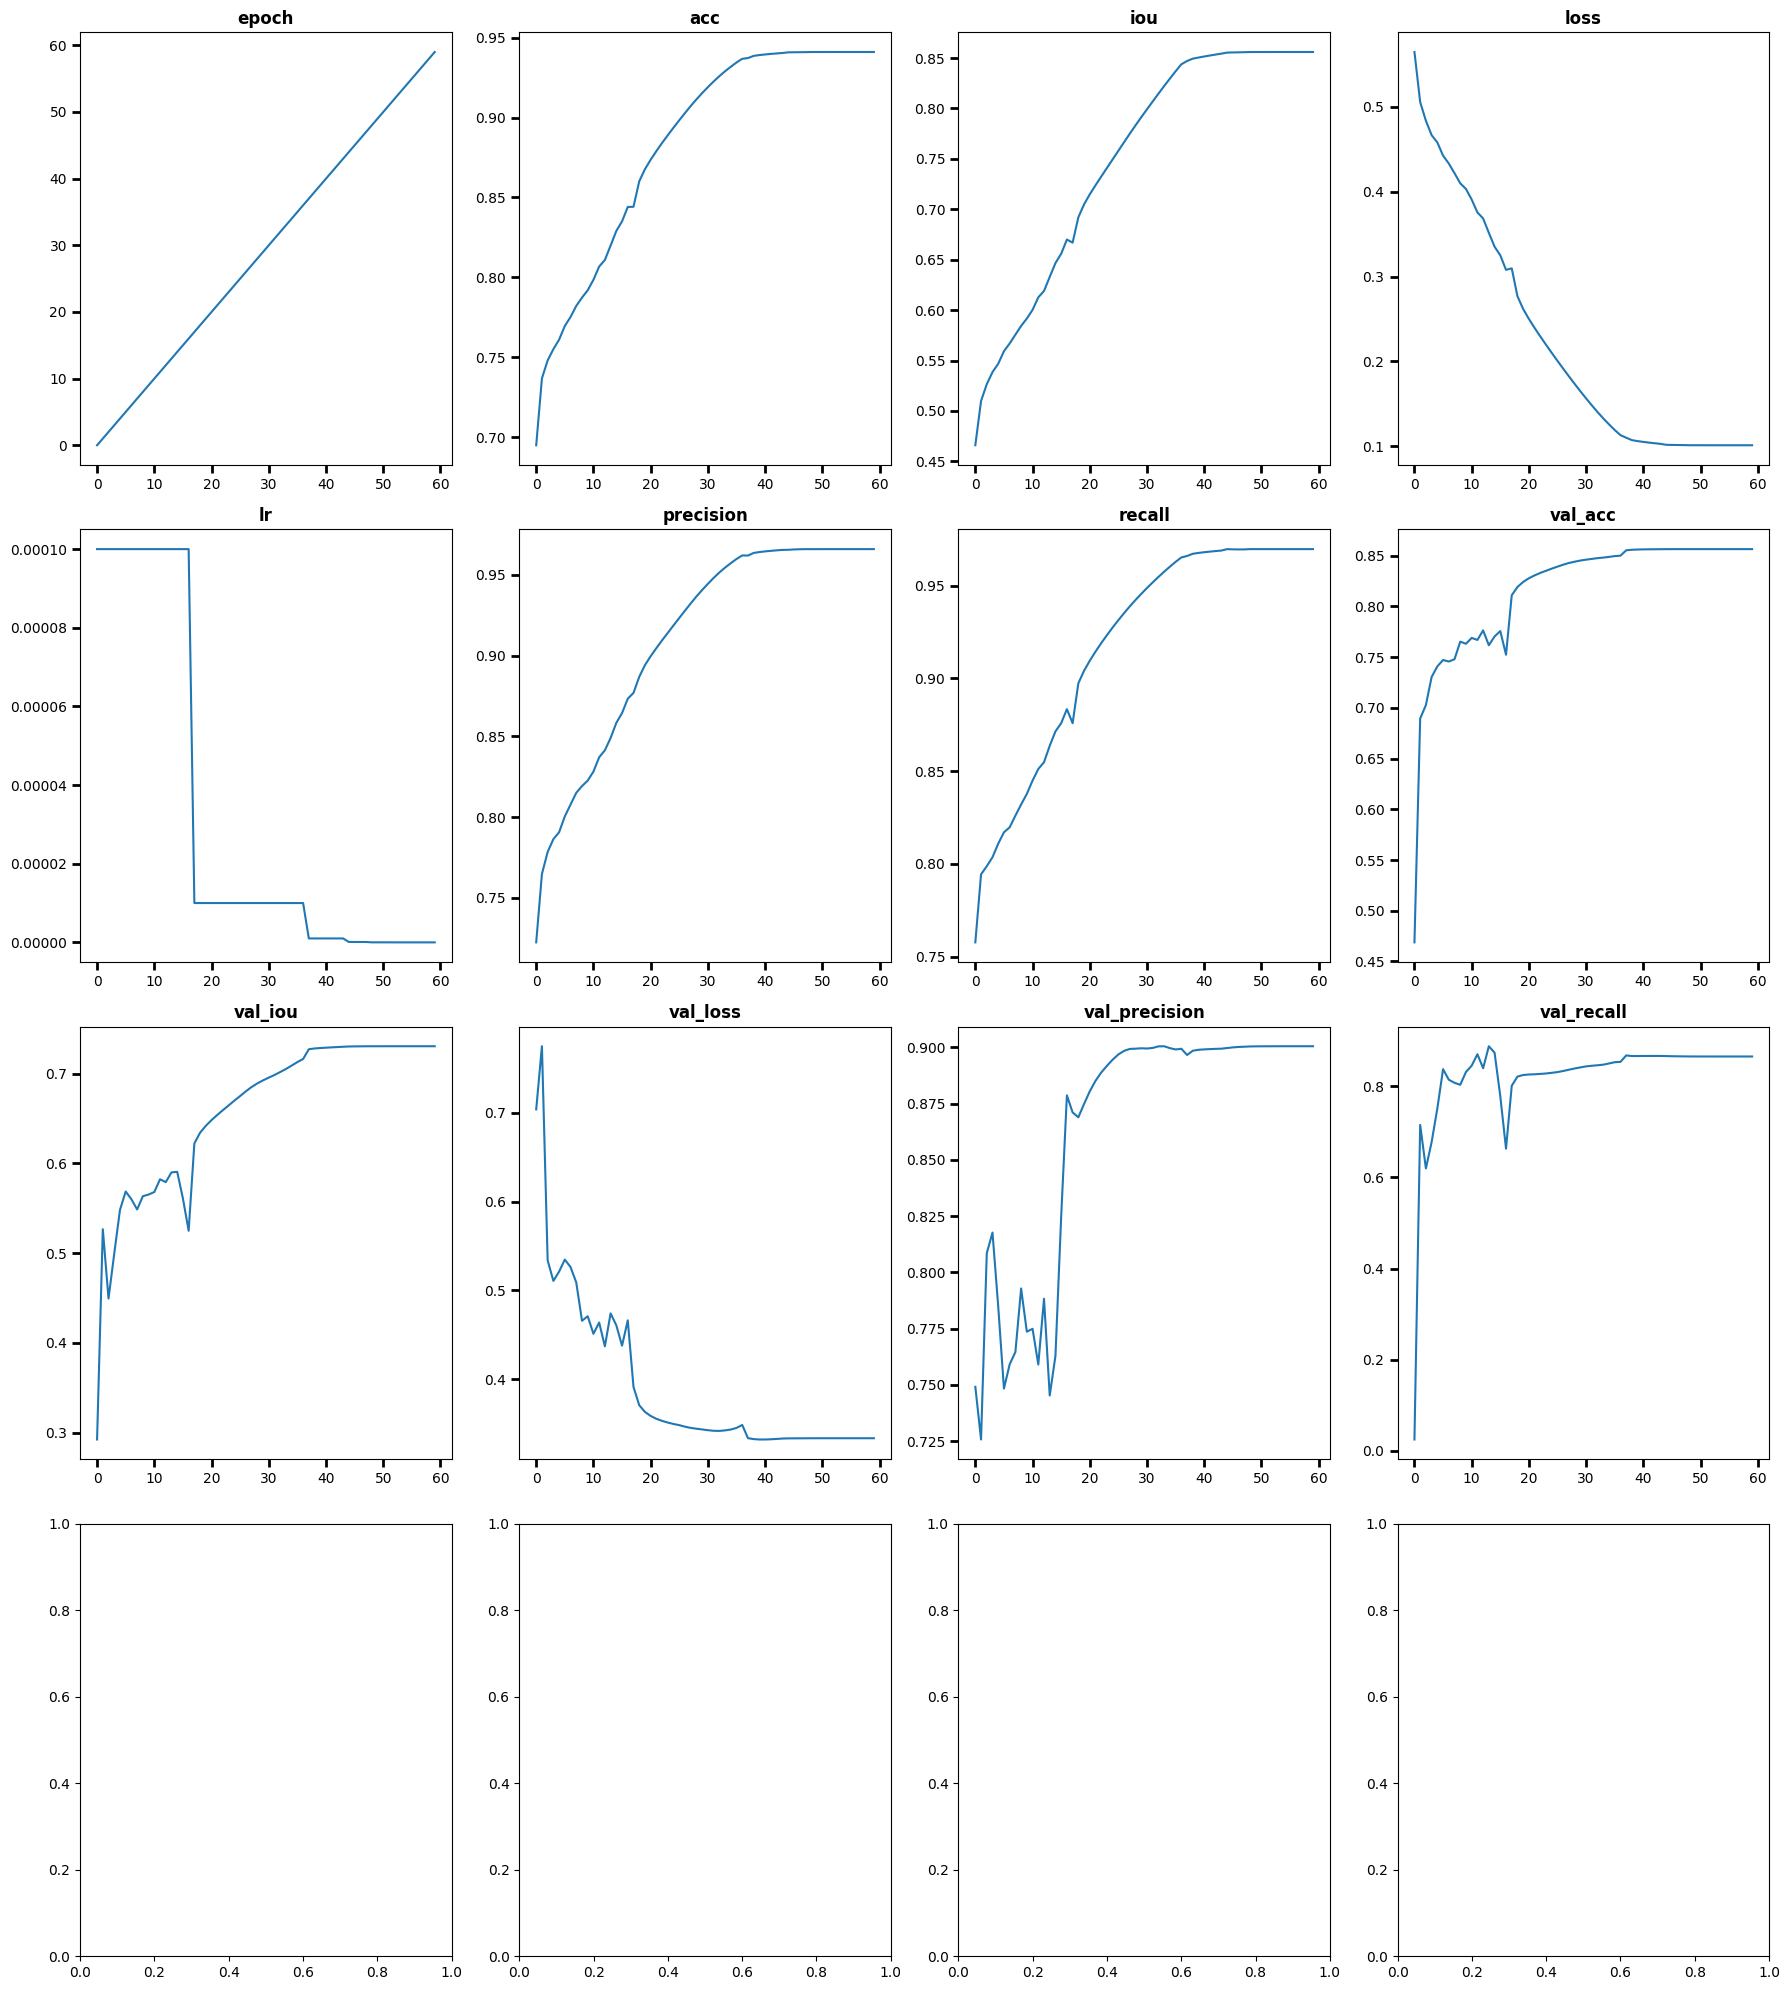

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv("/content/drive/MyDrive/segmentation_folder/log-non-aug.csv")

# Get the column names
columns = data.columns

# Calculate the number of rows and columns for subplots
num_rows = 4
num_cols = 4

# Create a figure with appropriate number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 20))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Iterate over the column names and plot the data
for i, column in enumerate(columns):
    axs[i].plot(data[column])
    axs[i].set_title(column, fontweight='bold')
    axs[i].tick_params(axis='both', which='major', labelsize=10, width=2, length=6)

# Adjust subplot spacing and display the plot
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 397ms/step


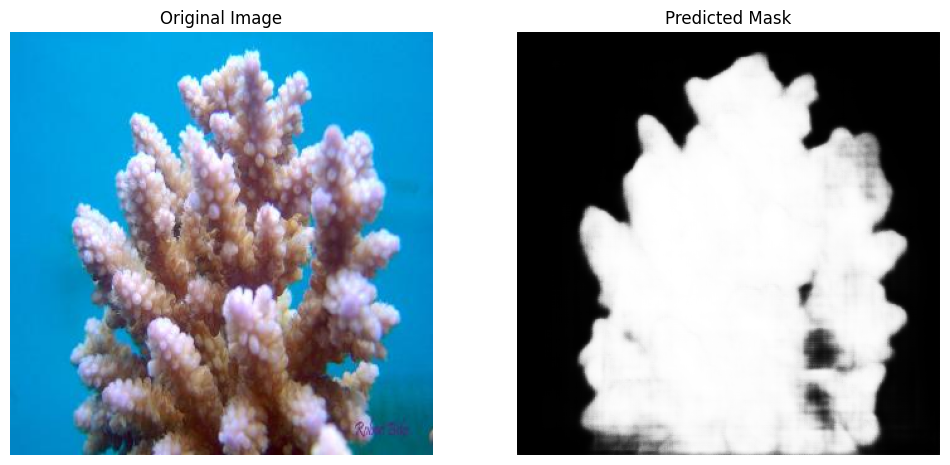

In [128]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define custom functions used during training
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
    iou = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7))
    return iou

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# Function to read and preprocess a single image
def read_single_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (336, 336))
    x = x / 255.0
    return x

# Function to predict mask for an image
def predict_mask(model, image_path):
    img = read_single_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    mask = model.predict(img)
    return mask.squeeze()  # Squeeze the mask to remove extra dimensions

if __name__ == "__main__":
    # Load the trained Keras model
    model_path = "/content/drive/MyDrive/segmentation_folder/unet-non-aug.keras"
    model = tf.keras.models.load_model(model_path, custom_objects={'iou': iou, 'precision': precision, 'recall': recall})

    # Path to the test image
    test_image_path = "/content/drive/MyDrive/segmentation_folder/test/images/Image_10_jpg.rf.575469d0cad41fc40b03cb87370ee6dd.jpg"

    # Generate prediction mask
    predicted_mask = predict_mask(model, test_image_path)

    # Read original image
    original_image = cv2.imread(test_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display original image and predicted mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    plt.show()


1/1 [==============================] - 0s 397ms/step


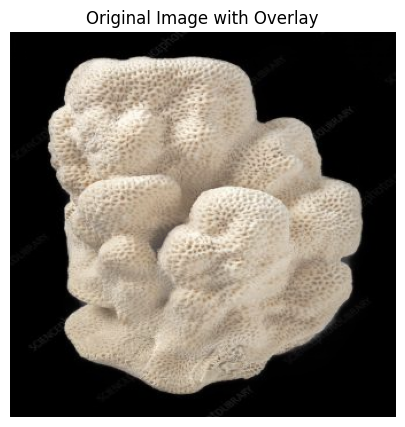

In [135]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Define custom functions used during training
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
    iou = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7))
    return iou

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# Function to read and preprocess a single image
def read_single_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (336, 336))
    x = x / 255.0
    return x

# Function to predict masks for a set of images
def predict_masks(model, image_paths):
    masks = []
    for path in image_paths:
        img = read_single_image(path)
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        mask = model.predict(img)
        masks.append(mask.squeeze())  # Squeeze the mask to remove extra dimensions
    return masks

if __name__ == "__main__":
    # Load the trained model
    model_path = "/content/drive/MyDrive/segmentation_folder/unet-non-aug.keras"
    model = tf.keras.models.load_model(model_path, custom_objects={'iou': iou, 'precision': precision, 'recall': recall})

    # Paths to test images
    test_image_paths = ["/content/drive/MyDrive/segmentation_folder/test/images/Image_10_jpg.rf.b1059e1a98a3413350bbd8e288f62cc7.jpg"]

    # Generate predictions
    predicted_masks = predict_masks(model, test_image_paths)

    # Display original images with overlaid masks
    for i, (image_path, mask) in enumerate(zip(test_image_paths, predicted_masks)):
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Resize mask to match the shape of the original image
        mask_resized = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]))

        # Convert mask to 3 channels
        mask_rgb = np.zeros_like(original_image)
        mask_rgb[:, :, 0] = mask_resized * 255  # Red channel
        mask_rgb[:, :, 1] = mask_resized * 255  # Green channel
        mask_rgb[:, :, 2] = mask_resized * 255  # Blue channel

        # Overlay mask on the original image
        overlaid_image = cv2.addWeighted(original_image, 0.7, mask_rgb, 0.3, 0)

        plt.figure(figsize=(10, 5))
        plt.imshow(overlaid_image)
        plt.title('Original Image with Overlay')
        plt.axis('off')
        plt.show()
